# By: Thomas Isola
## Class: PUI 2018
## HW #12 Assignment 2

In [1]:
import pandas as pd
import zipfile
import os
import pylab as pl
import urllib
import geopandas as gpd
import sklearn.cluster
from scipy.cluster.vq import kmeans2
from sklearn import mixture

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Check if PUIdata exists
import os
print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/ti582/PUIdata


In [3]:
# Download the Census data
files = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08',
        '09', '10', '11', '12', '13', '14']
i = 0
for item in files:
    url = 'https://github.com/fedhere/PUI2018_fb55/blob/master/HW12_fb55/zbp' + '%s'%files[i] + 'totals.zip?raw=true'
    urllib.request.urlretrieve(url, 'zbp' + '%s'%files[i] + 'totals.zip')
    file = 'zbp' + '%s'%files[i] + 'totals.zip'
    unzippedfile = zipfile.ZipFile(file, 'r')
    unzippedfile.extractall(os.getenv('PUIDATA'))
    i = i + 1

In [4]:
# Download the NYC zipcodes shapefile
url = 'https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip'
urllib.request.urlretrieve(url, 'nyczipsshp.zip')
unzipped = zipfile.ZipFile('nyczipsshp.zip', 'r')
unzipped.extractall(os.getenv('PUIDATA'))

In [5]:
# Printing information about the NYC zipcodes
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
#nyczipsshp.plot()
#nyczipsshp.drop_duplicates("ZIPCODE").plot()
#nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


In [6]:
# Display the NYC zipcodes data
nyczipsshp.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [7]:
# Remove unnecessary columns from NYC Zip Codes
nyczipsshp2 = nyczipsshp[['ZIPCODE','SHAPE_AREA','SHAPE_LEN','geometry']]
nyczipsshp2.loc[:,'ZIPCODE'] = nyczipsshp2['ZIPCODE'].astype('int64')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
# Convert the census data to dataframes and place them in a dictionary
ind = ['94', '95', '96', '97', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']
d = {}
for item in ind:
    d[item]= pd.read_csv(os.getenv('PUIDATA') + '/zbp' + '%s'%item + 'totals.txt')
    placeholder = d[item]
    placeholder = placeholder[['zip','est']]
    placeholder.rename(columns={'zip':'ZIPCODE'}, inplace=True)
    d[item] = placeholder

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [9]:
# Continue converting the census data to dataframes and placing them in a dictionary
ind2 = ['98', '99', '00', '01', '02']
for item in ind2:
    d[item]= pd.read_csv(os.getenv('PUIDATA') + '/zbp' + '%s'%item + 'totals.txt')
    placeholder = d[item]
    placeholder = placeholder[['ZIP','EST']]
    placeholder.rename(columns={'ZIP':'ZIPCODE','EST':'est'}, inplace=True)
    d[item] = placeholder

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [10]:
# Merge the Census and NYC Zipcodes data
for item in d.keys():
    nyczipsshp2 = nyczipsshp2.merge(d[item], on='ZIPCODE')
    nyczipsshp2.rename(index=str, columns={'est':'est'+'%s'%item}, inplace=True)
nyczipsshp2.head()

,ZIPCODE,SHAPE_AREA,SHAPE_LEN,geometry,est99,est11,est96,est03,est02,est05,...,est98,est07,est04,est14,est94,est09,est13,est95,est97,est10
0,11436,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",58,101,53,74,78,82,...,51,84,84,109,51,92,99,50,51,98
1,11213,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",473,674,433,569,546,556,...,476,556,570,772,406,621,755,420,456,675
2,11212,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",541,713,502,581,577,587,...,519,587,586,752,505,647,731,494,527,699
3,11225,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",409,597,388,488,479,491,...,416,514,492,696,381,543,673,387,410,580
4,11218,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",1149,1523,1049,1247,1228,1332,...,1118,1377,1295,1736,985,1457,1687,1015,1075,1474


In [11]:
# Create a new dataframe without the geometric info
columns = list(range(4,25))
columns.insert(0,0)
cleancsb = nyczipsshp2.iloc[:, columns]
cleancsb.drop('ZIPCODE', axis=1, inplace=True)
cleancsb = pd.DataFrame(cleancsb)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# Standardize the new dataframe
vals = ( (cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1) ).T
vals.reset_index(inplace=True)
vals.drop(['index'], axis=1, inplace=True)

In [13]:
# Check that the mean is 0
print(vals.mean(1))

0     -2.960595e-16
1     -1.480297e-16
2      4.758099e-16
3     -1.691768e-16
4     -2.749124e-16
5      7.507222e-16
6     -1.110223e-16
7     -3.383537e-16
8      2.801991e-16
9      3.806479e-16
10     7.930164e-18
11    -1.488888e-15
12     5.868322e-16
13     7.930164e-16
14     2.273314e-16
15     2.273314e-16
16    -8.458842e-17
17    -1.152517e-15
18    -1.152517e-15
19    -1.152517e-15
20     4.070818e-16
21     8.987520e-17
22     6.502735e-16
23     1.163091e-16
24    -5.709718e-16
25    -6.344132e-16
26    -4.255855e-16
27     6.079793e-16
28    -7.665826e-16
29    -1.993115e-15
           ...     
213   -2.236967e-16
214    2.061843e-16
215    4.229421e-17
216    4.097252e-17
217    1.638901e-16
218    1.427430e-16
219    6.767074e-16
220    5.286776e-17
221    1.110223e-16
222   -6.747248e-16
223    4.758099e-16
224    2.273314e-16
225    4.229421e-16
226   -3.119198e-16
227   -1.225871e-16
228    2.220446e-16
229    1.691768e-16
230   -6.661338e-16
231    5.286776e-18


The mean values are all very close to 0, which is what is desired.

In [14]:
# Check the shape of the mean
print(vals.mean(1).shape)

(243,)


The shape matches the number of zipcodes, which is desired.

In [15]:
# Check that the standard deviation is 0
print(vals.std(1))

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
10     1.0
11     1.0
12     1.0
13     1.0
14     1.0
15     1.0
16     1.0
17     1.0
18     1.0
19     1.0
20     1.0
21     1.0
22     1.0
23     1.0
24     1.0
25     1.0
26     1.0
27     1.0
28     1.0
29     1.0
      ... 
213    1.0
214    1.0
215    1.0
216    1.0
217    1.0
218    1.0
219    1.0
220    1.0
221    1.0
222    1.0
223    1.0
224    1.0
225    1.0
226    1.0
227    1.0
228    1.0
229    1.0
230    1.0
231    1.0
232    1.0
233    1.0
234    1.0
235    1.0
236    1.0
237    1.0
238    1.0
239    1.0
240    1.0
241    1.0
242    1.0
dtype: float64


The standard deviation values are all 1, which is desired.

In [16]:
# Check the shape of the standard deviation
print(vals.std(1).shape)

(243,)


The shape matches the number of zipcodes, which is desired.

In [17]:
# Perform the clustering with kmeans
nc = 5
km = sklearn.cluster.KMeans(n_clusters=nc, random_state=300).fit(vals)

5 clusters seems to be a reasonable choice.

In [18]:
# Add labels column to dataframe
kmlabels = pd.DataFrame(km.labels_, columns=['labels'])
vals2 = pd.concat((vals, kmlabels), axis=1)

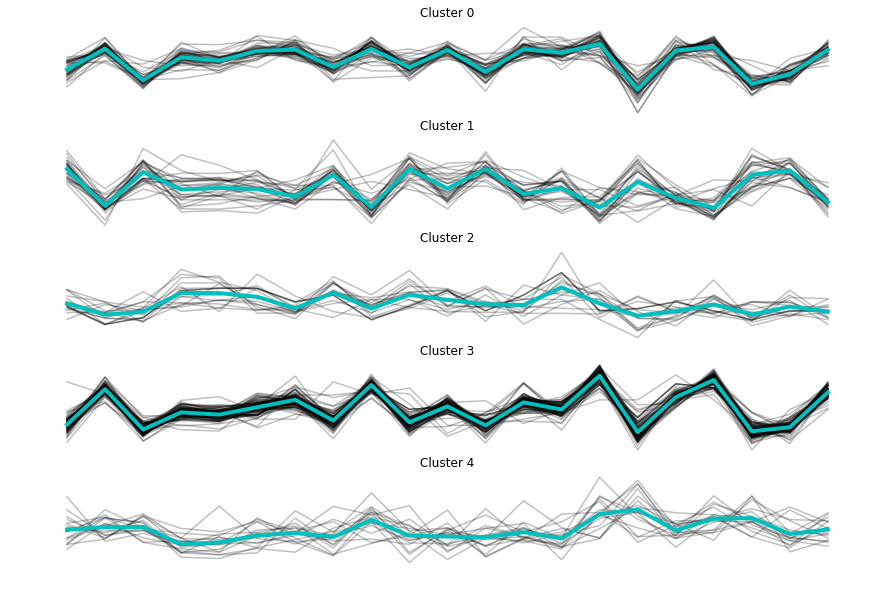

In [26]:
figs, ax = pl.subplots(5, 1, figsize=(15,10))
for i in range(5):
    center = vals2[vals2.loc[:,'labels'] == i].drop(['labels'], axis=1)
    for j in center.T:
        ax[i].plot(range(21), center.loc[j], 'k-', alpha=0.25)
        ax[i].axis('off')
        ax[i].set_title('Cluster %s'%i)
    ax[i].plot(range(21), center.mean(0), 'c-', linewidth=4)

**Figure 1**: The above is a plot of the cluster centers overlayed on top of each time series. The cluster center is shown in a thick cyan line and each time series is shown as semi-transparent black lines. As shown above, the clusters are grouped quite nicely given that there is not much spread outside of the average and the average appears to be well-centered for each cluster. 

In [20]:
# Reset the index
nyczipsshp3 = nyczipsshp2.reset_index()
nyczipsshp3.drop(['index'], axis=1, inplace=True)

In [21]:
# Add KMeans labels to the GeoDataFrame
nyczipsshp3['labels'] = kmlabels

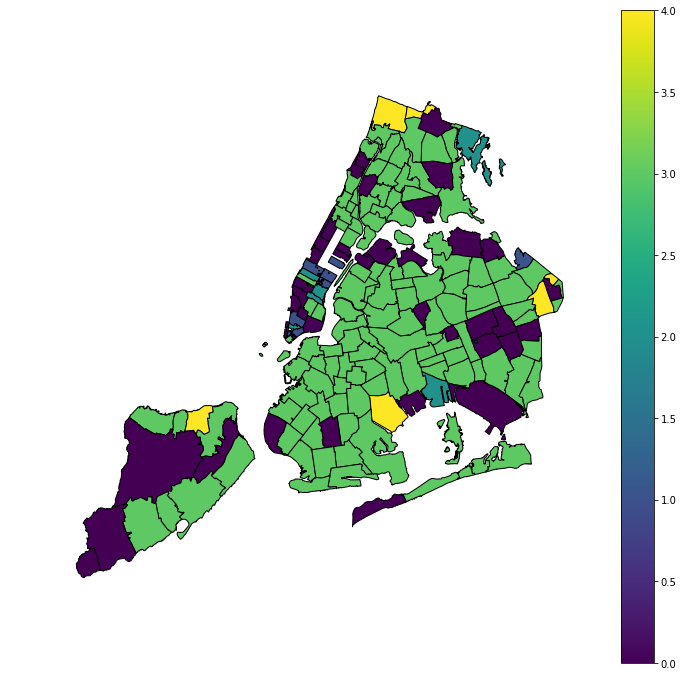

In [25]:
# Plot the results of the KMeans clustering on the NYC map
plot1 = nyczipsshp3.plot(column='labels',figsize=(12,12),cmap='viridis',alpha=1,
                          linewidth=1, edgecolor='black', legend=True)
plot1.axis('off');

**Figure 2**: Above is a plot of the 5 clusters of the number of establishments in NYC. The establishments data comes from the US Census and the map of NYC comes from NYC Open Data. The legend on the right hand side of the plot shows the colors that correspond to each cluster. Cluster 0, at the bottom, is purple, while cluster 4, at the top, is yellow. The plot shows that, in general, clusters 0, 2, and 4 are not geographically close to each other while clusters 1 and 3 are. My educated guess is that cluster 3 is the average number of establishments for an urban environment like New York City, which is why it takes up most of the plot. Cluster 1 seems to represent a high-number of establishments in zipcodes all next to each in Midtown Manhattan. Cluster 4 is most likely a cluster of small numbers of establishments. It is difficult to say what clusters 0 and 2 represent.  